<a href="https://colab.research.google.com/github/SunshineGreeny/Dive-into-deep-learning-Pytorch/blob/main/chapter_attention-mechanisms-and-transformers/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Transformer Architecture



In [84]:
import math
import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt

def try_gpu(i=0):
    """返回可用的GPU，否则返回CPU"""
    if torch.cuda.device_count() >= i+1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')


def bleu(preq_seq,label_seq,k=2):
  return sentence_bleu([label_seq.split()],
             preq_seq.split(),
             smoothing_function=SmoothingFunction().method1,
             weights=(1. / k,) * k)


def check_shape(tensor, expected_shape):
    assert tensor.shape == expected_shape, \
        f"Expected shape: {expected_shape}, but got: {tensor.shape}"
    return tensor


def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(3.5, 2.5),
                  sharex=True,sharey=True,squeeze=False):
    num_rows,num_cols=matrices.shape[0],matrices.shape[1]

    # 创建子图网络
    fig,axes=plt.subplots(num_rows,num_cols,figsize=figsize,
                          sharex=True,sharey=True,squeeze=False)
    # 遍历所有矩阵并绘制热力图
    for i in range(num_rows):
        for j in range(num_cols):
            ax=axes[i,j]
            # 将张量转换为numpy数组并分离计算图
            matrix=matrices[i,j].detach().numpy()

            # 使用热力图显示矩阵
            pcm=ax.imshow(matrix,cmap='Reds')

            # 设置坐标轴标签
            if i==num_rows-1:#最后一行显示x轴标签
                ax.set_xlabel(xlabel)
            if j==0:#第一列显示y轴标签
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])

            # 隐藏刻度线
            ax.xaxis.set_ticks_position('none')
            ax.yaxis.set_ticks_position('none')

    # Add a colorbar
    fig.colorbar(pcm, ax=axes.ravel().tolist())
    plt.show()


def masked_softmax(X, valid_lens):
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)

        # 创建掩码：对于每个位置，如果索引小于有效长度则为True，否则为False
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]

        # 将掩码为False的位置设置为指定的值
        X[~mask] = value
        return X

    # 没有提供有效长度，直接返回标准sofemax
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape

        # 处理不同维度的有效长度
        if valid_lens.dim() == 1:
            # 如果是一维,复制到每个位置
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)

        # 应用序列掩码,将无效位置设置为很小的值
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)

        # 应用softmax并恢复原始形状
        return nn.functional.softmax(X.reshape(shape), dim=-1)


class DotProductAttention(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        # 获取特征维度（用于缩放）
        d = queries.shape[-1]

        # 计算注意力分数：Q * K^T / √d
        # bmm: 批量矩阵乘法
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)

        # 应用带掩码的softmax得到注意力权重
        self.attention_weights = masked_softmax(scores, valid_lens)

        # 对注意力权重应用dropout，然后与值相乘得到最终输出
        return torch.bmm(self.dropout(self.attention_weights), values)


class MultiHeadAttention(nn.Module):
    """Multi-head attention."""
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

    def transpose_qkv(self, X):
        """Transposes the last two dimensions of a tensor."""
        X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
        X = X.permute(0, 2, 1, 3)
        return X.reshape(-1, X.shape[2], X.shape[3])

    def transpose_output(self, X):
        """Reverse the operation of transpose_qkv."""
        X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
        X = X.permute(0, 2, 1, 3)
        return X.reshape(X.shape[0], X.shape[1], -1)


    def forward(self, queries, keys, values, valid_lens):
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))

        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        output = self.attention(queries, keys, values, valid_lens)
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)


class MTFraEng(Dataset):
    def __init__(self, src_sentences, tgt_sentences, src_vocab, tgt_vocab, max_len):
        self.src_sentences = src_sentences
        self.tgt_sentences = tgt_sentences
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.src_sentences)

    def __getitem__(self, idx):
        src_sentence = self.src_sentences[idx]
        tgt_sentence = self.tgt_sentences[idx]

        src_tokens = ['<bos>'] + src_sentence.split() + ['<eos>']
        tgt_tokens = ['<bos>'] + tgt_sentence.split() + ['<eos>']

        src_indices = [self.src_vocab[token] for token in src_tokens if token in self.src_vocab]
        tgt_indices = [self.tgt_vocab[token] for token in tgt_tokens if token in self.tgt_vocab]

        # 填充或截断到固定长度
        src_indices = self.pad_or_truncate(src_indices, self.max_len, self.src_vocab['<pad>'])
        tgt_indices = self.pad_or_truncate(tgt_indices, self.max_len, self.tgt_vocab['<pad>'])

        return torch.tensor(src_indices), torch.tensor(tgt_indices)

    def pad_or_truncate(self, sequence, max_len, pad_token):
        if len(sequence) < max_len:
            return sequence + [pad_token] * (max_len - len(sequence))
        else:
            return sequence[:max_len]

    def build_vocab(sentences, min_freq=2):
        tokens = []
        for sentence in sentences:
            tokens.extend(sentence.split())

        token_freq = {}
        for token in tokens:
            token_freq[token] = token_freq.get(token, 0) + 1

        vocab = {'<pad>': 0, '<bos>': 1, '<eos>': 2}
        for token, freq in token_freq.items():
            if freq >= min_freq:
                vocab[token] = len(vocab)

        # Add get_itos method for demonstration
        vocab['get_itos'] = lambda: {v: k for k, v in vocab.items()}

        return vocab

    def build(self, src_sentences, tgt_sentences):
        """Builds the dataset for prediction."""
        src_indices = []
        tgt_indices = []
        for src_sentence, tgt_sentence in zip(src_sentences, tgt_sentences):
            src_tokens = ['<bos>'] + src_sentence.split() + ['<eos>']
            tgt_tokens = ['<bos>'] + tgt_sentence.split() + ['<eos>']
            src_indices.append([self.src_vocab[token] for token in src_tokens if token in self.src_vocab])
            tgt_indices.append([self.tgt_vocab[token] for token in tgt_tokens if token in self.tgt_vocab])

        # Pad or truncate to max_len
        src_indices = [self.pad_or_truncate(indices, self.max_len, self.src_vocab['<pad>']) for indices in src_indices]
        tgt_indices = [self.pad_or_truncate(indices, self.max_len, self.tgt_vocab['<pad>']) for indices in tgt_indices]

        return torch.tensor(src_indices), torch.tensor(tgt_indices)


class PositionalEncoding(nn.Module):
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)


def Trainer(model, train_loader, val_loader, num_epochs, lr, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # 忽略填充token
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        total_train_loss = 0
        for src, tgt in train_loader:
            src, tgt = src.to(device), tgt.to(device)

            optimizer.zero_grad()
            enc_outputs = model.encoder(src, None)
            state = model.decoder.init_state(enc_outputs, None)

            # 解码器输入是目标序列去掉最后一个token
            dec_input = tgt[:, :-1]
            # 解码器输出应该预测目标序列去掉第一个token
            dec_output, _ = model.decoder(dec_input, state)

            loss = criterion(dec_output.reshape(-1, dec_output.shape[-1]), tgt[:, 1:].reshape(-1))
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # 验证阶段
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for src, tgt in val_loader:
                src, tgt = src.to(device), tgt.to(device)

                enc_outputs = model.encoder(src, None)
                state = model.decoder.init_state(enc_outputs, None)
                dec_input = tgt[:, :-1]
                dec_output, _ = model.decoder(dec_input, state)

                loss = criterion(dec_output.reshape(-1, dec_output.shape[-1]), tgt[:, 1:].reshape(-1))
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # 绘制损失曲线
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, tgt_vocab):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.tgt_vocab = tgt_vocab

    def forward(self, src, tgt):
        enc_outputs = self.encoder(src, None)
        dec_state = self.decoder.init_state(enc_outputs, None)
        dec_input = tgt[:, :-1]
        logits, _ = self.decoder(dec_input, dec_state)
        return logits

    def predict_step(self, src_seqs, device, max_len, save_attention_weights=False):
        """Predict the output sequence."""
        self.eval()
        batch_size = len(src_seqs)
        enc_outputs = self.encoder(src_seqs.to(device), None)
        dec_state = self.decoder.init_state(enc_outputs, None)
        # Start with the <bos> token
        dec_X = torch.tensor([self.tgt_vocab['<bos>']] * batch_size,
                             device=device).unsqueeze(1)
        preds = []
        attention_weights = []
        for _ in range(max_len):
            Y, dec_state = self.decoder(dec_X, dec_state)
            # Use the token with the highest predicted probability as the next
            # input to the decoder
            dec_X = Y.argmax(dim=2)
            preds.extend(dec_X.squeeze(1).tolist())
            # Save attention weights (optional)
            if save_attention_weights:
                attention_weights.append(self.decoder.attention_weights)
        return torch.tensor(preds).reshape(batch_size, -1), attention_weights

In [86]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    train_dataset.build(engs, fras)[0], try_gpu(), train_dataset.max_len)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    # Get the index-to-token mapping from tgt_vocab
    itos = train_dataset.tgt_vocab.get('get_itos')()
    for idx in p:
        token = itos.get(idx.item(), '<unk>') # Handle unknown tokens
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {" ".join(translation)}, bleu: {bleu(" ".join(translation), fr, k=2):.3f}')

go . => phrase phrase phrase phrase, bleu: 0.000
i lost . => phrase phrase, bleu: 0.000
he's calm . => , bleu: 0.000
i'm home . => , bleu: 0.000


Positionwise Feed-Forward Networks

In [87]:
class PositionWiseFFN(nn.Module):
    """The positionwise feed-forward network."""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

The innermost dimension
of a tensor changes

In [88]:
ffn = PositionWiseFFN(4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[ 0.0465,  0.0788,  0.3235,  0.4165,  0.0498,  0.4642,  0.1853, -0.7265],
        [ 0.0465,  0.0788,  0.3235,  0.4165,  0.0498,  0.4642,  0.1853, -0.7265],
        [ 0.0465,  0.0788,  0.3235,  0.4165,  0.0498,  0.4642,  0.1853, -0.7265]],
       grad_fn=<SelectBackward0>)

Compares the normalization across different dimensions
by layer normalization and batch normalization

In [89]:
ln = nn.LayerNorm(2)
bn = nn.LazyBatchNorm1d()
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


Using a residual connection followed by layer normalization

In [90]:
class AddNorm(nn.Module):
    """The residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

The output tensor also has the same shape after the addition operation

In [91]:
add_norm = AddNorm(4, 0.5)
shape = (2, 3, 4)
check_shape(add_norm(torch.ones(shape), torch.ones(shape)), shape)

tensor([[[ 1.0000, -1.0000,  1.0000, -1.0000],
         [-0.5773, -0.5773,  1.7320, -0.5773],
         [-1.7320,  0.5773,  0.5773,  0.5773]],

        [[-0.5773, -0.5773, -0.5773,  1.7320],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [-0.5773,  1.7320, -0.5773, -0.5773]]],
       grad_fn=<NativeLayerNormBackward0>)

A single layer within the encoder

In [92]:
class TransformerEncoderBlock(nn.Module):
    """The Transformer encoder block."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False):
        super().__init__()
        self.attention = MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

No layer in the Transformer encoder
changes the shape of its input

In [93]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = TransformerEncoderBlock(24, 48, 8, 0.5)
encoder_blk.eval()
check_shape(encoder_blk(X, valid_lens), X.shape)

tensor([[[-1.2984, -0.1359,  0.3096,  ...,  0.5380, -0.7653, -2.2785],
         [-1.2984, -0.1359,  0.3096,  ...,  0.5380, -0.7653, -2.2785],
         [-1.2984, -0.1359,  0.3096,  ...,  0.5380, -0.7653, -2.2785],
         ...,
         [-1.2984, -0.1359,  0.3096,  ...,  0.5380, -0.7653, -2.2785],
         [-1.2984, -0.1359,  0.3096,  ...,  0.5380, -0.7653, -2.2785],
         [-1.2984, -0.1359,  0.3096,  ...,  0.5380, -0.7653, -2.2785]],

        [[-1.2984, -0.1359,  0.3096,  ...,  0.5380, -0.7653, -2.2785],
         [-1.2984, -0.1359,  0.3096,  ...,  0.5380, -0.7653, -2.2785],
         [-1.2984, -0.1359,  0.3096,  ...,  0.5380, -0.7653, -2.2785],
         ...,
         [-1.2984, -0.1359,  0.3096,  ...,  0.5380, -0.7653, -2.2785],
         [-1.2984, -0.1359,  0.3096,  ...,  0.5380, -0.7653, -2.2785],
         [-1.2984, -0.1359,  0.3096,  ...,  0.5380, -0.7653, -2.2785]]],
       grad_fn=<NativeLayerNormBackward0>)

Transformer encoder

In [94]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X, state):
        raise NotImplementedError

class TransformerEncoder(Encoder):
    """The Transformer encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

Create a two-layer Transformer encoder

In [95]:
encoder = TransformerEncoder(200, 24, 48, 8, 2, 0.5)
check_shape(encoder(torch.ones((2, 100), dtype=torch.long), valid_lens),
                (2, 100, 24))

tensor([[[ 1.6328, -0.2081, -0.3183,  ...,  0.7240,  0.7417, -0.7519],
         [ 2.1505, -1.1120, -1.0962,  ...,  0.4878, -0.7146,  1.7423],
         [ 0.6959, -2.7280, -0.9335,  ...,  1.8036,  0.8220,  0.0223],
         ...,
         [ 0.3222, -2.6411,  0.8195,  ..., -0.0887,  0.1686, -0.1338],
         [ 0.0075, -1.6291, -1.2814,  ...,  1.3070, -0.6245,  0.2580],
         [ 0.7588, -1.5963, -0.6898,  ...,  0.3817, -0.1676, -0.3626]],

        [[-0.7526, -2.3025, -0.4650,  ...,  1.3041,  0.3129,  0.2736],
         [-0.0354, -2.9566, -1.1695,  ...,  1.2462,  0.1550,  0.1720],
         [ 0.9399, -1.4026, -0.7288,  ...,  0.2909, -1.6188, -0.9122],
         ...,
         [ 1.2546, -1.8168, -2.5204,  ...,  0.8915, -0.7470, -0.6593],
         [ 0.4081, -0.8309, -0.7258,  ...,  0.8154, -0.5159,  2.2473],
         [-0.2156, -1.9926, -0.3780,  ...,  0.8413, -1.2228,  0.5877]]],
       grad_fn=<NativeLayerNormBackward0>)

The Transformer decoder
is composed of multiple identical layers

In [96]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

The feature dimension (`num_hiddens`) of the decoder is
the same as that of the encoder

In [97]:
decoder_blk = TransformerDecoderBlock(24, 48, 8, 0.5, 0)
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
check_shape(decoder_blk(X, state)[0], X.shape)

tensor([[[ 0.7944, -0.0115, -1.3728,  ...,  2.7082, -0.0115, -0.0115],
         [ 0.0973, -0.9764,  0.2271,  ...,  0.9557, -0.6859,  0.3234],
         [ 0.6463,  0.7715,  0.3443,  ...,  0.9696, -1.3846,  0.4463],
         ...,
         [ 1.1936,  0.1253,  0.9504,  ...,  0.2600, -1.0014, -0.1411],
         [-0.3928, -0.5539,  0.8695,  ...,  1.8133, -1.3378,  0.6781],
         [ 0.0769, -1.4487,  0.6110,  ..., -0.0482,  0.4381,  0.4799]],

        [[-0.8750,  0.2938,  0.6980,  ...,  1.7486, -1.7476, -0.4366],
         [-0.4498, -0.1895, -0.1149,  ...,  1.6065, -2.2317,  0.1432],
         [ 0.2064, -0.0987,  0.2126,  ..., -1.2603, -1.6655,  0.4486],
         ...,
         [ 1.5198,  0.0764,  0.2350,  ...,  1.6023, -1.2868, -0.2341],
         [ 1.0288, -1.5092,  0.1551,  ...,  2.5236, -0.5689,  0.5736],
         [-0.0675, -1.1564,  0.3698,  ...,  1.9828, -0.7424,  0.7560]]],
       grad_fn=<NativeLayerNormBackward0>)

In [98]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = TransformerEncoderBlock(24, 48, 8, 0.5)
encoder_blk.eval()
check_shape(encoder_blk(X, valid_lens), X.shape)

tensor([[[-0.8539, -1.9368,  0.2662,  ..., -0.5859, -0.8179, -1.3145],
         [-0.8539, -1.9368,  0.2662,  ..., -0.5859, -0.8179, -1.3145],
         [-0.8539, -1.9368,  0.2662,  ..., -0.5859, -0.8179, -1.3145],
         ...,
         [-0.8539, -1.9368,  0.2662,  ..., -0.5859, -0.8179, -1.3145],
         [-0.8539, -1.9368,  0.2662,  ..., -0.5859, -0.8179, -1.3145],
         [-0.8539, -1.9368,  0.2662,  ..., -0.5859, -0.8179, -1.3145]],

        [[-0.8539, -1.9368,  0.2662,  ..., -0.5859, -0.8179, -1.3145],
         [-0.8539, -1.9368,  0.2662,  ..., -0.5859, -0.8179, -1.3145],
         [-0.8539, -1.9368,  0.2662,  ..., -0.5859, -0.8179, -1.3145],
         ...,
         [-0.8539, -1.9368,  0.2662,  ..., -0.5859, -0.8179, -1.3145],
         [-0.8539, -1.9368,  0.2662,  ..., -0.5859, -0.8179, -1.3145],
         [-0.8539, -1.9368,  0.2662,  ..., -0.5859, -0.8179, -1.3145]]],
       grad_fn=<NativeLayerNormBackward0>)

In [99]:
encoder = TransformerEncoder(200, 24, 48, 8, 2, 0.5)
check_shape(encoder(torch.ones((2, 100), dtype=torch.long), valid_lens),
                (2, 100, 24))

tensor([[[-0.6597,  0.6768, -0.4830,  ..., -1.3499, -1.8011,  1.1326],
         [-0.2913,  1.5606, -0.2407,  ..., -0.0097,  0.1698,  0.9187],
         [-0.1141,  0.1341, -0.8392,  ..., -1.1081,  1.0573, -1.1886],
         ...,
         [-1.4992,  0.2245, -0.0517,  ..., -1.3164,  1.3622,  1.4649],
         [-1.1621, -0.3345,  1.7225,  ...,  0.1610, -0.1385, -0.1016],
         [ 0.5682,  0.2036,  1.0085,  ..., -1.1760, -0.8672, -0.4858]],

        [[-0.6270, -0.2028, -0.1038,  ...,  0.4740,  0.5518,  1.5729],
         [ 1.9980,  0.4119, -1.0642,  ..., -0.3191, -1.1076, -1.1698],
         [-0.3395, -0.3767, -0.2338,  ...,  0.0253, -0.9592,  0.5705],
         ...,
         [-0.2362,  0.1250,  0.4368,  ..., -0.5752, -0.1266,  2.1188],
         [ 0.3958,  0.1727,  0.6845,  ...,  1.1659, -0.4557,  0.4904],
         [ 0.2543,  0.9093, -0.5758,  ..., -0.3291,  0.4705,  0.8205]]],
       grad_fn=<NativeLayerNormBackward0>)

In [100]:
decoder_blk = TransformerDecoderBlock(24, 48, 8, 0.5, 0)
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
check_shape(decoder_blk(X, state)[0], X.shape)

tensor([[[ 0.0873, -0.2148,  1.0626,  ..., -0.3677,  1.0703, -1.7591],
         [-1.1862, -1.5900, -0.0111,  ..., -1.1303,  0.5276, -0.0288],
         [ 0.1243, -1.5262,  0.4868,  ...,  0.4730, -0.0355, -0.5456],
         ...,
         [ 0.1038, -1.4244, -0.5633,  ..., -0.8434,  0.1038, -0.6194],
         [ 1.6781, -0.3705,  0.3294,  ..., -1.3547,  0.6927, -1.0662],
         [-0.3306, -0.1985,  0.4503,  ..., -0.3734,  0.8151, -2.1793]],

        [[ 0.5206, -0.1208,  0.4271,  ..., -2.0531, -0.2590,  0.9654],
         [-0.1230, -0.4757, -1.8668,  ..., -1.9179,  0.4973, -0.3273],
         [ 0.7480, -0.3303,  0.3996,  ..., -0.0478, -0.0478, -0.5260],
         ...,
         [-0.9144,  0.2782, -0.4582,  ..., -0.2601,  0.4170, -0.8046],
         [-0.2759, -0.3137, -0.6557,  ..., -0.5467,  2.6535, -2.0156],
         [ 0.0753,  0.1993, -0.1599,  ..., -0.1168,  2.6164, -0.9373]]],
       grad_fn=<NativeLayerNormBackward0>)

In [101]:
decoder_blk = TransformerDecoderBlock(24, 48, 8, 0.5, 0)
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
check_shape(decoder_blk(X, state)[0], X.shape)

tensor([[[ 1.4798, -2.7548,  0.0801,  ...,  0.0982, -0.1093,  0.3784],
         [ 0.4682, -0.3309, -0.4186,  ..., -0.5783, -0.0941,  0.6198],
         [-0.3885,  0.0033,  0.0272,  ...,  0.0439,  0.8811, -0.1710],
         ...,
         [-0.2643, -0.6946, -0.9970,  ..., -0.8023,  1.0421,  0.7694],
         [ 0.1760,  0.2756, -0.0068,  ...,  0.0699,  0.7362, -0.0872],
         [ 0.4310, -0.1902, -0.1009,  ...,  0.0416,  0.1035,  1.0703]],

        [[ 0.5459,  0.0978, -0.8832,  ...,  0.1914, -0.1453, -0.8722],
         [-0.0342, -0.1700, -0.6476,  ..., -0.4945,  0.2086,  0.2199],
         [ 0.2641,  0.2625,  0.3038,  ...,  0.0230, -0.2503, -0.7653],
         ...,
         [ 0.4671, -0.0592, -0.9684,  ..., -0.3266, -0.2259, -0.5233],
         [-0.1350,  0.3406,  0.3648,  ...,  0.9393,  1.8573,  0.3589],
         [-0.0526,  0.6370, -0.2622,  ..., -0.1412,  0.1700,  0.8063]]],
       grad_fn=<NativeLayerNormBackward0>)

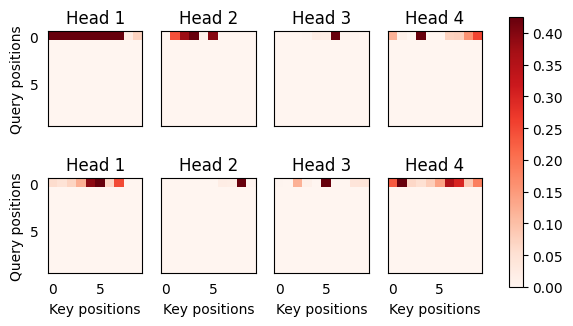

In [111]:
import pandas as pd
import torch

# dec_attention_weights from predict_step is a list of attention weights for each decoding step.
# Each element is a list of two lists: [self_attention_weights_per_block, inter_attention_weights_per_block]
# self_attention_weights_per_block is a list of tensors, one for each block.
# Each self-attention tensor shape: (batch_size * num_heads, 1, current_decoded_len)
# Each inter-attention tensor shape: (batch_size * num_heads, 1, encoded_len)

# Assuming batch_size is 1 for visualization
batch_size_viz = 1
num_blks = model.decoder.num_blks
num_heads = model.decoder.blks[0].attention1.num_heads # Assuming all blocks have same number of heads
# Get encoded_len from the output of the encoder for a single example
single_example_src = train_dataset.build([engs[-1]], [fras[-1]])[0].to(try_gpu())
with torch.no_grad():
    encoded_len = model.encoder(single_example_src, None).shape[1]
max_len = train_dataset.max_len # Maximum decoding length

# Initialize tensors to store collected attention weights
# Shape: (num_blks, num_heads, max_len, max_len) for self-attention
# Shape: (num_blks, num_heads, max_len, encoded_len) for inter-attention
dec_self_attention_weights_viz = torch.zeros(num_blks, num_heads, max_len, max_len)
dec_inter_attention_weights_viz = torch.zeros(num_blks, num_heads, max_len, encoded_len)


for step_idx, step_weights in enumerate(dec_attention_weights):
    # step_weights is a list of two lists: [self_attn_per_block, inter_attn_per_block]
    self_attn_per_block = step_weights[0] # List of tensors, one per block
    inter_attn_per_block = step_weights[1] # List of tensors, one per block

    for blk_idx in range(num_blks):
        # Self-attention weights for the current block and step
        # Shape (batch_size * num_heads, 1, current_decoded_len)
        self_attn_tensor = self_attn_per_block[blk_idx]
        current_decoded_len = self_attn_tensor.shape[-1]

        # Reshape to (batch_size, num_heads, 1, current_decoded_len) and take the first example
        self_attn_tensor = self_attn_tensor.reshape(batch_size_viz, num_heads, 1, current_decoded_len)[0, :, 0, :] # Shape (num_heads, current_decoded_len)

        # Store self-attention weights in the visualization tensor
        # The query position is the current step_idx
        # The key positions are from 0 to current_decoded_len - 1
        dec_self_attention_weights_viz[blk_idx, :, step_idx, :current_decoded_len] = self_attn_tensor


        # Inter-attention weights for the current block and step
        # Shape (batch_size * num_heads, 1, encoded_len)
        inter_attn_tensor = inter_attn_per_block[blk_idx]

        # Reshape to (batch_size, num_heads, 1, encoded_len) and take the first example
        inter_attn_tensor = inter_attn_tensor.reshape(batch_size_viz, num_heads, 1, encoded_len)[0, :, 0, :] # Shape (num_heads, encoded_len)

        # Store inter-attention weights in the visualization tensor
        # The query position is the current step_idx
        # The key positions are from 0 to encoded_len - 1
        dec_inter_attention_weights_viz[blk_idx, :, step_idx, :] = inter_attn_tensor


# Now the collected tensors have the desired shape for visualization


# Adjust expected shape based on the actual data structure and the single example used for visualization
expected_self_attn_shape = (num_blks, num_heads, max_len, max_len)
expected_inter_attn_shape = (num_blks, num_heads, max_len, encoded_len)


check_shape(dec_self_attention_weights_viz, expected_self_attn_shape)
check_shape(dec_inter_attention_weights_viz, expected_inter_attn_shape)

show_heatmaps(
    dec_self_attention_weights_viz.cpu(),
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, num_heads + 1)], figsize=(7, 3.5))

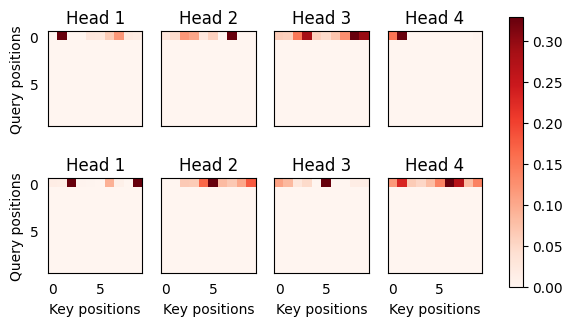

In [103]:
show_heatmaps(
    dec_inter_attention_weights_viz, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, num_heads + 1)],
    figsize=(7, 3.5))

Construct the entire Transformer decoder

In [104]:
class AttentionDecoder(nn.Module):
    def __init__(self):
        super().__init__()

    def init_state(self, enc_outputs, enc_valid_lens):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

class TransformerDecoder(AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout, tgt_vocab):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)
        self.tgt_vocab = tgt_vocab

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

Training

Epoch [1/30], Train Loss: 1.5157, Val Loss: 0.2606
Epoch [2/30], Train Loss: 0.2265, Val Loss: 0.2143
Epoch [3/30], Train Loss: 0.1227, Val Loss: 0.1036
Epoch [4/30], Train Loss: 0.0605, Val Loss: 0.0951
Epoch [5/30], Train Loss: 0.0271, Val Loss: 0.0597
Epoch [6/30], Train Loss: 0.0082, Val Loss: 0.0311
Epoch [7/30], Train Loss: 0.0041, Val Loss: 0.0170
Epoch [8/30], Train Loss: 0.0038, Val Loss: 0.0105
Epoch [9/30], Train Loss: 0.0023, Val Loss: 0.0073
Epoch [10/30], Train Loss: 0.0020, Val Loss: 0.0053
Epoch [11/30], Train Loss: 0.0017, Val Loss: 0.0044
Epoch [12/30], Train Loss: 0.0021, Val Loss: 0.0042
Epoch [13/30], Train Loss: 0.0026, Val Loss: 0.0097
Epoch [14/30], Train Loss: 0.0018, Val Loss: 0.0084
Epoch [15/30], Train Loss: 0.0017, Val Loss: 0.0078
Epoch [16/30], Train Loss: 0.0019, Val Loss: 0.0066
Epoch [17/30], Train Loss: 0.0014, Val Loss: 0.0056
Epoch [18/30], Train Loss: 0.0017, Val Loss: 0.0046
Epoch [19/30], Train Loss: 0.0014, Val Loss: 0.0037
Epoch [20/30], Train 

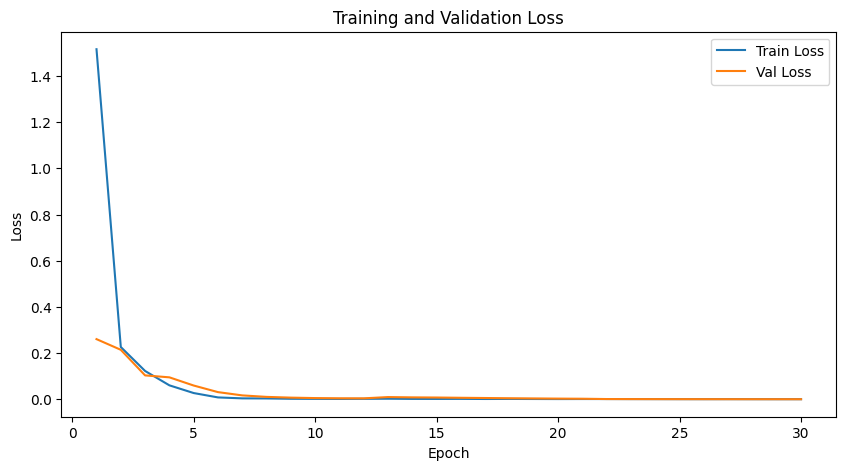

In [108]:
# Assuming you have a function to load/create your source and target sentences
# For example:
# src_sentences = ["This is an example.", "Another sentence."]
# tgt_sentences = ["C'est un exemple.", "Une autre phrase."]

# You need to define or load your source and target sentences here
# For demonstration, let's create dummy data:
src_sentences = ["This is an example sentence.", "Another sentence here."]
tgt_sentences = ["C'est une phrase d'exemple.", "Une autre phrase ici."]

# Build vocabularies
src_vocab = MTFraEng.build_vocab(src_sentences)
tgt_vocab = MTFraEng.build_vocab(tgt_sentences)

max_len = 10 # Define your maximum sequence length

# Instantiate the Dataset
train_dataset = MTFraEng(src_sentences, tgt_sentences, src_vocab, tgt_vocab, max_len)

# Define batch size
batch_size = 128

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=batch_size) # Using train_dataset for validation for demonstration

num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4

encoder = TransformerEncoder(
    len(src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout, tgt_vocab)

# The Seq2Seq model needs the pad token index for the target
model = Seq2Seq(encoder, decoder)

# Define training parameters
num_epochs = 30
lr = 0.001
device = try_gpu() # Assuming try_gpu() is defined elsewhere to get a device

# Call the Trainer function with the correct arguments
Trainer(model, train_loader, val_loader, num_epochs, lr, device)

In [109]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def bleu(preq_seq,label_seq,k=2):
  return sentence_bleu([label_seq.split()],
             preq_seq.split(),
             smoothing_function=SmoothingFunction().method1,
             weights=(1. / k,) * k)

engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    train_dataset.build(engs, fras)[0], try_gpu(), train_dataset.max_len)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    # Get the index-to-token mapping from tgt_vocab
    itos = train_dataset.tgt_vocab.get('get_itos')()
    for idx in p:
        token = itos.get(idx.item(), '<unk>') # Handle unknown tokens
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {" ".join(translation)}, bleu: {bleu(" ".join(translation), fr, k=2):.3f}')

go . => phrase phrase phrase phrase, bleu: 0.000
i lost . => , bleu: 0.000
he's calm . => , bleu: 0.000
i'm home . => , bleu: 0.000


Translate a few English sentences

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def bleu(preq_seq,label_seq,k=2):
  return sentence_bleu([label_seq.split()],
             preq_seq.split(),
             smoothing_function=SmoothingFunction().method1,
             weights=(1. / k,) * k)

engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    train_dataset.build(engs, fras)[0], try_gpu(), train_dataset.max_len)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    # Get the index-to-token mapping from tgt_vocab
    itos = train_dataset.tgt_vocab.get('get_itos')()
    for idx in p:
        token = itos.get(idx.item(), '<unk>') # Handle unknown tokens
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {" ".join(translation)}, bleu: {bleu(" ".join(translation), fr, k=2):.3f}')

Visualize the Transformer attention weights

In [ ]:
_, dec_attention_weights = model.predict_step(
    train_dataset.build([engs[-1]], [fras[-1]])[0], try_gpu(), train_dataset.max_len, True)
enc_attention_weights = torch.cat(model.encoder.attention_weights, 0)
shape = (num_blks, num_heads, -1, train_dataset.max_len)
enc_attention_weights = enc_attention_weights.reshape(shape)
check_shape(enc_attention_weights,
                (num_blks, num_heads, train_dataset.max_len, train_dataset.max_len))

show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, num_heads + 1)],
    figsize=(7, 3.5))

To visualize the decoder self-attention weights and the encoder--decoder attention weights,
we need more data manipulations

In [ ]:
import pandas as pd
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weights
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
shape = (-1, 2, num_blks, num_heads, train_dataset.max_len)
dec_attention_weights = dec_attention_weights_filled.reshape(shape)
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)

check_shape(dec_self_attention_weights,
                (num_blks, num_heads, train_dataset.max_len, train_dataset.max_len))
check_shape(dec_inter_attention_weights,
                (num_blks, num_heads, train_dataset.max_len, train_dataset.max_len))

show_heatmaps(
    dec_self_attention_weights[:, :, :, :],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, num_heads + 1)], figsize=(7, 3.5))

In [ ]:
# Assuming you have a function to load/create your source and target sentences
# For example:
# src_sentences = ["This is an example.", "Another sentence."]
# tgt_sentences = ["C'est un exemple.", "Une autre phrase."]

# You need to define or load your source and target sentences here
# For demonstration, let's create dummy data:
src_sentences = ["This is an example sentence.", "Another sentence here."]
tgt_sentences = ["C'est une phrase d'exemple.", "Une autre phrase ici."]

# Build vocabularies
src_vocab = MTFraEng.build_vocab(src_sentences)
tgt_vocab = MTFraEng.build_vocab(tgt_sentences)

max_len = 10 # Define your maximum sequence length

# Instantiate the Dataset
train_dataset = MTFraEng(src_sentences, tgt_sentences, src_vocab, tgt_vocab, max_len)

# Define batch size
batch_size = 128

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=batch_size) # Using train_dataset for validation for demonstration

num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4

encoder = TransformerEncoder(
    len(src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout, tgt_vocab)

# The Seq2Seq model needs the pad token index for the target
model = Seq2Seq(encoder, decoder, tgt_vocab)

# Define training parameters
num_epochs = 30
lr = 0.001
device = try_gpu() # Assuming try_gpu() is defined elsewhere to get a device

# Call the Trainer function with the correct arguments
Trainer(model, train_loader, val_loader, num_epochs, lr, device)

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def bleu(preq_seq,label_seq,k=2):
  return sentence_bleu([label_seq.split()],
             preq_seq.split(),
             smoothing_function=SmoothingFunction().method1,
             weights=(1. / k,) * k)

engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    train_dataset.build(engs, fras)[0], try_gpu(), train_dataset.max_len)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    # Get the index-to-token mapping from tgt_vocab
    itos = train_dataset.tgt_vocab.get('get_itos')()
    for idx in p:
        token = itos.get(idx.item(), '<unk>') # Handle unknown tokens
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {" ".join(translation)}, bleu: {bleu(" ".join(translation), fr, k=2):.3f}')

No query from the output sequence
attends to those padding tokens from the input sequence

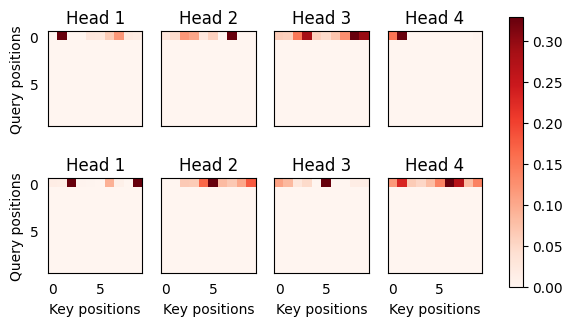

In [112]:
show_heatmaps(
    dec_inter_attention_weights_viz.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, num_heads + 1)],
    figsize=(7, 3.5))